In [3]:
%load_ext autoreload
%autoreload 2
from render import Renderer
import torch
from PIL import Image
from tqdm import tqdm
import os

import kaolin
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def trilinear_torch(xyz, data):
    '''
    xyz: array with coordinates inside data
    data: 3d volume
    returns: interpolated data values at coordinates
    '''
    H, W, D, _ = data.shape
    ijk = xyz.int()
    i, j, k = ijk[:,0], ijk[:,1], ijk[:,2]
    i, j, k = j, i, k
    
    i = i % H
    j = j % W
    k = k % D
    
    ii = (i + 1) % H
    jj = (j + 1) % W
    kk = (k + 1) % D
    
    
    V000 = data[ i   , j   ,  k   ].int()
    V100 = data[ii, j   ,  k   ].int()
    V010 = data[ i   ,jj,  k   ].int()
    V001 = data[ i   , j   , kk].int()
    V101 = data[ii, j   , kk].int()
    V011 = data[ i   ,jj, kk].int()
    V110 = data[ii,jj,  k   ].int()
    V111 = data[ii,jj, kk].int()
    
    xyz = xyz - ijk
    x, y, z = xyz[:,0:1], xyz[:,1:2], xyz[:,2:3]
    Vxyz = (V000 * (1 - x)*(1 - y)*(1 - z)
            + V100 * x * (1 - y) * (1 - z) +
            + V010 * (1 - x) * y * (1 - z) +
            + V001 * (1 - x) * (1 - y) * z +
            + V101 * x * (1 - y) * z +
            + V011 * (1 - x) * y * z +
            + V110 * x * y * (1 - z) +
            + V111 * x * y * z)
    return Vxyz

# Render by face color (Interpolation)

In [66]:
kmesh.vertices.shape

torch.Size([11141, 3])

Number of vertices, and faces = (10242, 20480)
Number of vertices, and faces after subdivision = (163842, 327680)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


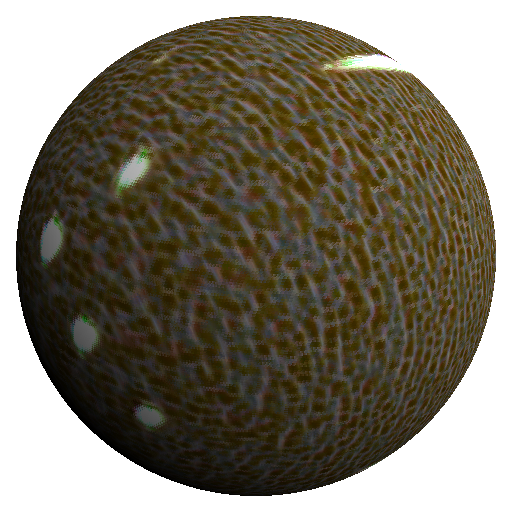

In [345]:
from video_utils import VideoWriter
import os

mesh_name = "sphere"
kmesh = kaolin.io.obj.import_mesh(f"./meshes/{mesh_name}_remesh_lvl1.obj")

mesh2camera = {
    "cube": (np.pi / 3, np.pi / 5.5, [0, -0.1, 0.15], 1.8), # exact look at not relative to the camera pos
    # "mug": (np.pi / 5, np.pi / 4, [-0.4, -0.0, 0.0], 1.7),
    "dragon": (np.pi / 4, np.pi / 5, [0.0, -0.15, -0.35], 1.7),
    "bunny": (np.pi / 4, np.pi / 8, [0.4, 0.05, 0.3], 1.4),
    "armadillo": (1.15 * np.pi / 2, 0, [0.0, 0.08, -0.25], 1.55),
    "armor": (np.pi / 3, np.pi / 36, [0.0, 0.0, 1.0], 1.6),
    "mobius": (np.pi / 3, np.pi / 6, [-0.0, -0.3, -0.3], 1.9),
    "seashell": (np.pi / 12, 0, [-0.0, -0.0, -0.0], 1.9),
    "springer": (np.pi / 4, np.pi / 6, [0.6, -0.0, 0.6], 1.75),
    "hand": (np.pi / 3, np.pi / 6, [0.0, -0.43, 0.2], 1.6),
    "spot": (np.pi / 4, np.pi / 6, [0.0, -0.45, -0.4], 1.6),
    
    
}

device = torch.device("cuda:0")
W = 256 # for cube
# W = 512 # for cube

height, width = 512, 512
num_views = 1
renderer = Renderer(device=device, dim=(height, width))

V = kmesh.vertices[None, :].to(device)
V = (V - V.mean(dim=1, keepdim=True))
scale = torch.max(torch.norm(V, dim=2, p=2, keepdim=True))
V = V / scale

F = kmesh.faces.to(device)

print(f"Number of vertices, and faces = ({len(V[0])}, {len(F)})") 
V, F = kaolin.ops.mesh.subdivide_trianglemesh(V, F, 2)
print(f"Number of vertices, and faces after subdivision = ({len(V[0])}, {len(F)})")




texture_type = "p"
if texture_type == "t":
    model_path = "./Trained/"
else:
    model_path = "./Trained_pbr/"
    
video_path = f"renders/{texture_type}/{mesh_name}"
if not os.path.exists(video_path):
    os.mkdir(video_path)


for f in sorted(os.listdir(model_path)[:]):
    
    texture_name = f.split("_")[1]
    
    # if texture_name != "p1":
    #     continue
    if "ipynb" in f:
        continue

    with VideoWriter(filename=f"{video_path}/{texture_name}.mp4", fps=30, autoplay=False) as vid, torch.no_grad():
        volume = np.load(f"{model_path}/{f}/offline_ondemand_volume_{W}_{W}_{W}.npy").transpose(1, 2, 3, 0)
        if mesh_name in mesh2camera:
            starting_azimuth, elevation, look_at, render_radius = mesh2camera[mesh_name]
        else:
            elevation = np.pi / 6.0
            starting_azimuth = np.pi / 4.0
            look_at = None
            render_radius = 2.1
            
        

        volume = torch.from_numpy(volume).to(device)
        
        step = 0
        for azimuth in tqdm(np.linspace(0, 2 * np.pi, 180, dtype=np.float32)[:1]):
            
            azimuth = (azimuth + starting_azimuth).astype(np.float32)
            coords, masks, lighting = renderer.get_projected_coordinates(V, F, 
                                                               num_views=num_views,
                                                               center_elev=elevation, radius=render_radius,
                                                               center_azim=azimuth, look_at=look_at)
            coords = coords
            masks = masks[..., 0]

            xyz = (coords + 1.0) / 2.0
            xyz = 0.9 * (xyz - xyz.min()) / (xyz.max() - xyz.min()) + 0.05
            # xyz = xyz / np.sqrt(2.0) # for other meshes
            # xyz = xyz * 1.0 # for cube
            
            xyz = xyz.reshape(-1, 3)
            H, W, D, _ = volume.shape
            colors = trilinear_torch(xyz * H , volume) / 255.0
            colors = colors.reshape(num_views, height, width, 3)
            colors = torch.clip(colors * lighting, 0.0, 1.0)
            
            colors[masks == 0.0] = 1.0
            # colors[masks == 0.0] = 0.0
            

            colors = colors.cpu().numpy()
            masks = masks.cpu().numpy()
            img = masks[0]
            img = colors[0]
            # img = np.vstack([np.hstack(colors[i::2]) for i in range(2)])
        # 


            img = Image.fromarray((img * 255.0).astype(np.uint8))
            
            vid.add(img)
            if step == 0:
                img_L = img.resize((128, 128))
                img_L.save(f"renders/{texture_type}_img/{mesh_name}/L_ondemand_{texture_name}_{mesh_name}.png")
                img.save(f"renders/{texture_type}_img/{mesh_name}/ondemand_{texture_name}_{mesh_name}.png")
                
            step += 1
            
img

In [342]:
xyz.max(), xyz.min()

(tensor(0.6718, device='cuda:0'), tensor(0.0354, device='cuda:0'))

In [ ]:
obj_view_dict = {  'alien': [1.96349, 0.6283], 
                            'candle':[1.96349, 0.6283], 
                            'horse': [5.4, 0.4],
                            'lamp':  [1.96349, 0.6283],
                            'shoe':  [0.5, 0.6283],
                            'vase':  [pi / 4.0, pi / 6.0], 
                            'bunny': [pi / 4.0, pi / 8.0],
                             'springer': [pi / 4.0, pi / 8.0],
                            'sphere':[0.0, 0.0],
                            'sphere_5':[0.0, 0.0],
                            'sphere_6':[0.0, 0.0],
                            'plane128_triangle':[0.0, 1.57],
                            'plane128':[0.0, 1.57],
                            'cat':[1.96349, 0.6283],
                            'cow':[1.96349, 0.6283],
                            'spot':[pi / 4.0, pi / 6.0],
                             'mug':[pi / 4.0, pi / 6.0],
                             'chair':[pi / 4.0, pi / 6.0],
                            'mountain':[pi / 3.0 * 2.0, pi / 12.0],
                            'koala':[pi / 3.0, pi / 8.0],
                            'armor':[pi / 3.0, pi / 8.0]}
        self.view_dict.update(obj_view_dict)
        
        self.radius_dict = defaultdict(place_holder_radius)
        
        obj_radius_dict = { 'vase':  1.7, 
                            'bunny': 1.45,
                          'springer':1.75,
                          'mountain':1.6,
                          'mug':1.7,
                          'spot':1.8,
                          'chair':1.8,
                          'koala':1.5,
                          'armor':1.5,}
        self.radius_dict.update(obj_radius_dict)
        
        self.look_at_dict = defaultdict(place_holder_look_at)
        
        look_at_dict = {'bunny': [0.4, 0.0, 0.4],
                       'vase': [0.8, 0.0, 0.8],
                       'springer': [0.6, 0.0, 0.6],
                       'mountain': [-0.1, 0.5, 0.0],
                       'mug': [-0.4, 0.0, 0.0],
                       'spot':[0.0, 0.0, 0.0],
                      'chair':[-0.1, 0.0, -0.1],
                      'koala':[0.4, 0.0, -0.5],
                      'armor':[-0.4, 0.0, 0.0],}
        self.look_at_dict.update(look_at_dict)

# Render by vertex color

In [78]:
from render import Renderer
import torch
from PIL import Image

device = torch.device("cuda:0")

from tqdm import tqdm

height, width = 512, 512
num_views = 1

renderer = Renderer(device=device, dim=(height, width))

with torch.no_grad():
    xyz = (vertices + 1.0) / 2.1
    H, W, D, _ = volume.shape
    colors = trilinear_torch(xyz * H , volume) / 255.0
    
    V = kmesh.vertices[None, :].to(device) / 2.1
    F = kmesh.faces.to(device)    
    C = torch.tensor(colors, device=device, dtype=torch.float32)[None, :]
    O = renderer.render_fixed_views(V, F, C, lighting=False,
                                    num_views=num_views, 
                                    background=torch.tensor([1.0, 1.0, 1.0], device=device))
    O = O.detach().cpu().numpy().transpose(0, 2, 3, 1)
    img = O[0]
    # img = np.vstack([np.hstack(O[i::2]) for i in range(2)])
    
img = Image.fromarray((img * 255.0).astype(np.uint8))
img

AttributeError: 'numpy.ndarray' object has no attribute 'int'